# 1. Project Overview


The "Game of Deep Learning Ship Datasets" is a comprehensive dataset designed for ship classification tasks in computer vision. It contains high-quality images of ships belonging to five categories: Cargo, Military, Carrier, Cruise, and Tanker. The dataset is ideal for deep learning applications, offering diverse ship perspectives and environments, enabling robust model training. Each image is labeled, allowing deep learning and classification. Researchers can leverage this dataset for image preprocessing, augmentation, and advanced tasks like transfer learning or object detection. With its well-defined classes and visual diversity, it provides an excellent foundation for exploring deep learning models in maritime classification.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import cv2
import warnings
warnings.filterwarnings('ignore')

# Data Import and Analysis

Data sources: 

These datasets, which are prepared by Analytics Vidhya, are used for ship classification tasks in the "Game of Deep Learning: Ship Datasets" on Kaggle. Images of several ship kinds are included in this dataset, which was first assembled for a Deep Learning project. Each image is labeled with the appropriate category, enabling supervised learning applications. This dataset can be used by researchers and practitioners to create and assess machine learning models that are intended to precisely identify and categorize various ship types from visual data.

In [2]:
train = pd.read_csv("/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv")
path = "/kaggle/input/game-of-deep-learning-ship-datasets/train/images"



# Data Preprocessing

In [3]:
train.head()


,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


The bar chart shows the frequency count of each ship category, with "Cargo" being the most frequent, followed by "Military," "Tanker," "Carrier," and "Cruise" ships. This indicates an imbalance in the dataset, with "Cargo" dominating the sample size."Cargo" accounts for 33.9% of the dataset, while "Cruise" has the smallest share at 13.3%. These insights highlight the need for addressing class imbalance during model training to avoid biased predictions.

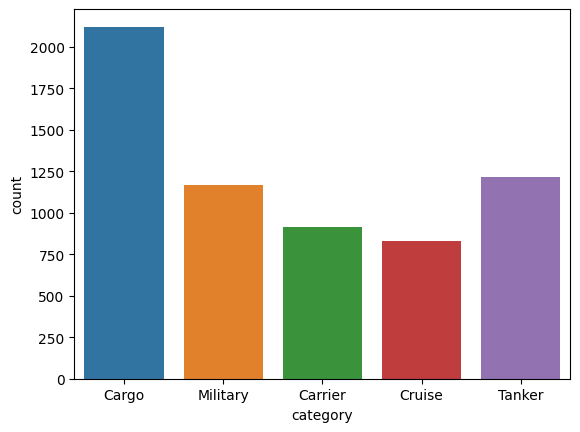

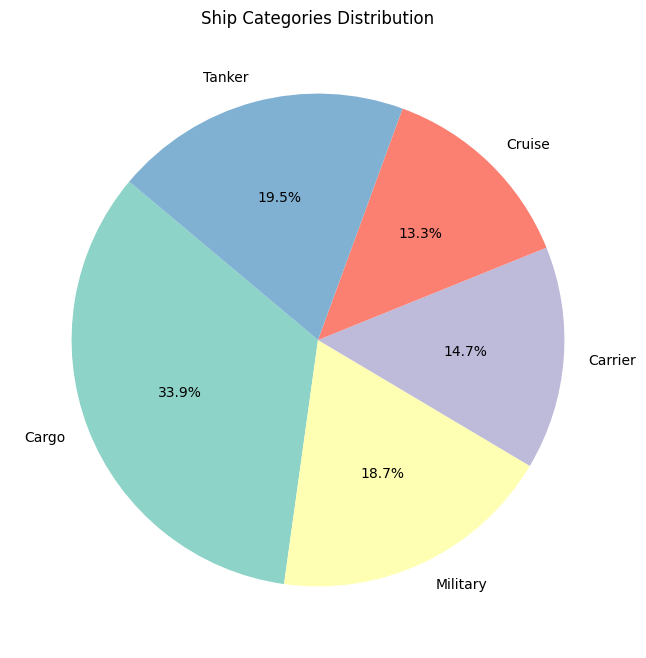

In [4]:
ship_categories = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}
sns.countplot(x=train["category"].map(ship_categories))
category_counts = train['category'].value_counts().sort_index()  # Ensure the counts align with the categories

# Map numerical categories to their names
labels_categories = [ship_categories[key] for key in category_counts.index]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=labels_categories, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Ship Categories Distribution')
plt.show()

The `load_and_preprocess_images` function is designed to prepare image data for machine learning tasks by loading, resizing, and normalizing it. It iterates through the dataset, constructing the full path for each image and loading it using `tf.keras.utils.load_img`, resizing each image to a specified size (128x128 in this case). The loaded images are converted into numerical arrays using `tf.keras.utils.img_to_array` and normalized to a range of [0, 1] by dividing pixel values by 255, which ensures compatibility and efficiency in neural network training. Each processed image is appended to a list, which is ultimately converted into a numpy array for numerical computations. This processed array, with a shape of `(6252, 128, 128, 3)`, represents 6252 RGB images, ready for model training.

In [5]:
def load_and_preprocess_images(train, image_column, base_path, refactor_size=128):
    image_list = []

    for i in range(len(train)):
        # Build the full path to the image
        image_path = os.path.join(base_path, train[image_column][i])
        
        # Load and resize the image
        img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
        
        # Convert the image to an array (RGB format)
        img_array = tf.keras.utils.img_to_array(img)
        
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        
        # Append the image array
        image_list.append(img_array)

    # Convert the list of images to a numpy array
    images_array = np.array(image_list)

    return images_array

images_array = load_and_preprocess_images(train, image_column='image', base_path=path, refactor_size=128)
print(f"Shape of the RGB images array: {images_array.shape}")  # (num_images, refactor_size, refactor_size, 3)


Shape of the RGB images array: (6252, 128, 128, 3)


# Resizing imaga datasets


1. Uniform Input Size: Deep learning models typically require input images of the same dimensions.
2. Resizing ensures that all images match the expected input size of the model, such as 128x128 in this case.
3. Memory Efficiency: Working with high-resolution images consumes more memory and computational resources.
4. Resizing reduces the resolution while retaining essential features, optimizing resource usage and processing Speed: Smaller images reduce computational load, improving training and inference speed without significant loss of crucial information.
5. Data Augmentation: Resized images provide a consistent starting point for additional preprocessing or augmentations.This step ensures the dataset is ready for model training and prediction.


In [6]:
def resize_images(train, image_column, base_path, refactor_size=128):

    resized_image_list = []
    all_paths = []

    for i in range(len(train)):
        # Build the full path to the image
        image_path = os.path.join(base_path, train[image_column][i])
        
        # Load and resize the image
        img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
        
        # Convert the image to float32 and an array
        img_vals = tf.image.convert_image_dtype(img, tf.float32)
        img_array = tf.keras.utils.img_to_array(img_vals)
        
        # Append the processed image and its path
        resized_image_list.append(img_array)
        all_paths.append(image_path)

    # Convert the list of images to a numpy array
    resized_images = np.asarray(resized_image_list)

    return resized_images, all_paths

resized_images, image_paths = resize_images(train, 'image', path, refactor_size=128)

# Output
print(f"Number of resized images: {len(resized_images)}")
print(f"Example image path: {image_paths[0]}")

Number of resized images: 6252
Example image path: /kaggle/input/game-of-deep-learning-ship-datasets/train/images/2823080.jpg


Feature extraction helps machine learning models concentrate on important details by emphasizing important aspects, such as ship outlines and forms. Dimensionality Reduction: Edge detection makes an image easier to interpret computationally by highlighting edges and removing extraneous information, such as background noise. Data Augmentation Visualization: By demonstrating how structural features are maintained, it visually confirms the impact of data augmentation approaches. Preprocessing for Models: Preprocessed images with improved feature representation help models such as convolutional neural networks (CNNs) learn more accurately and efficiently.

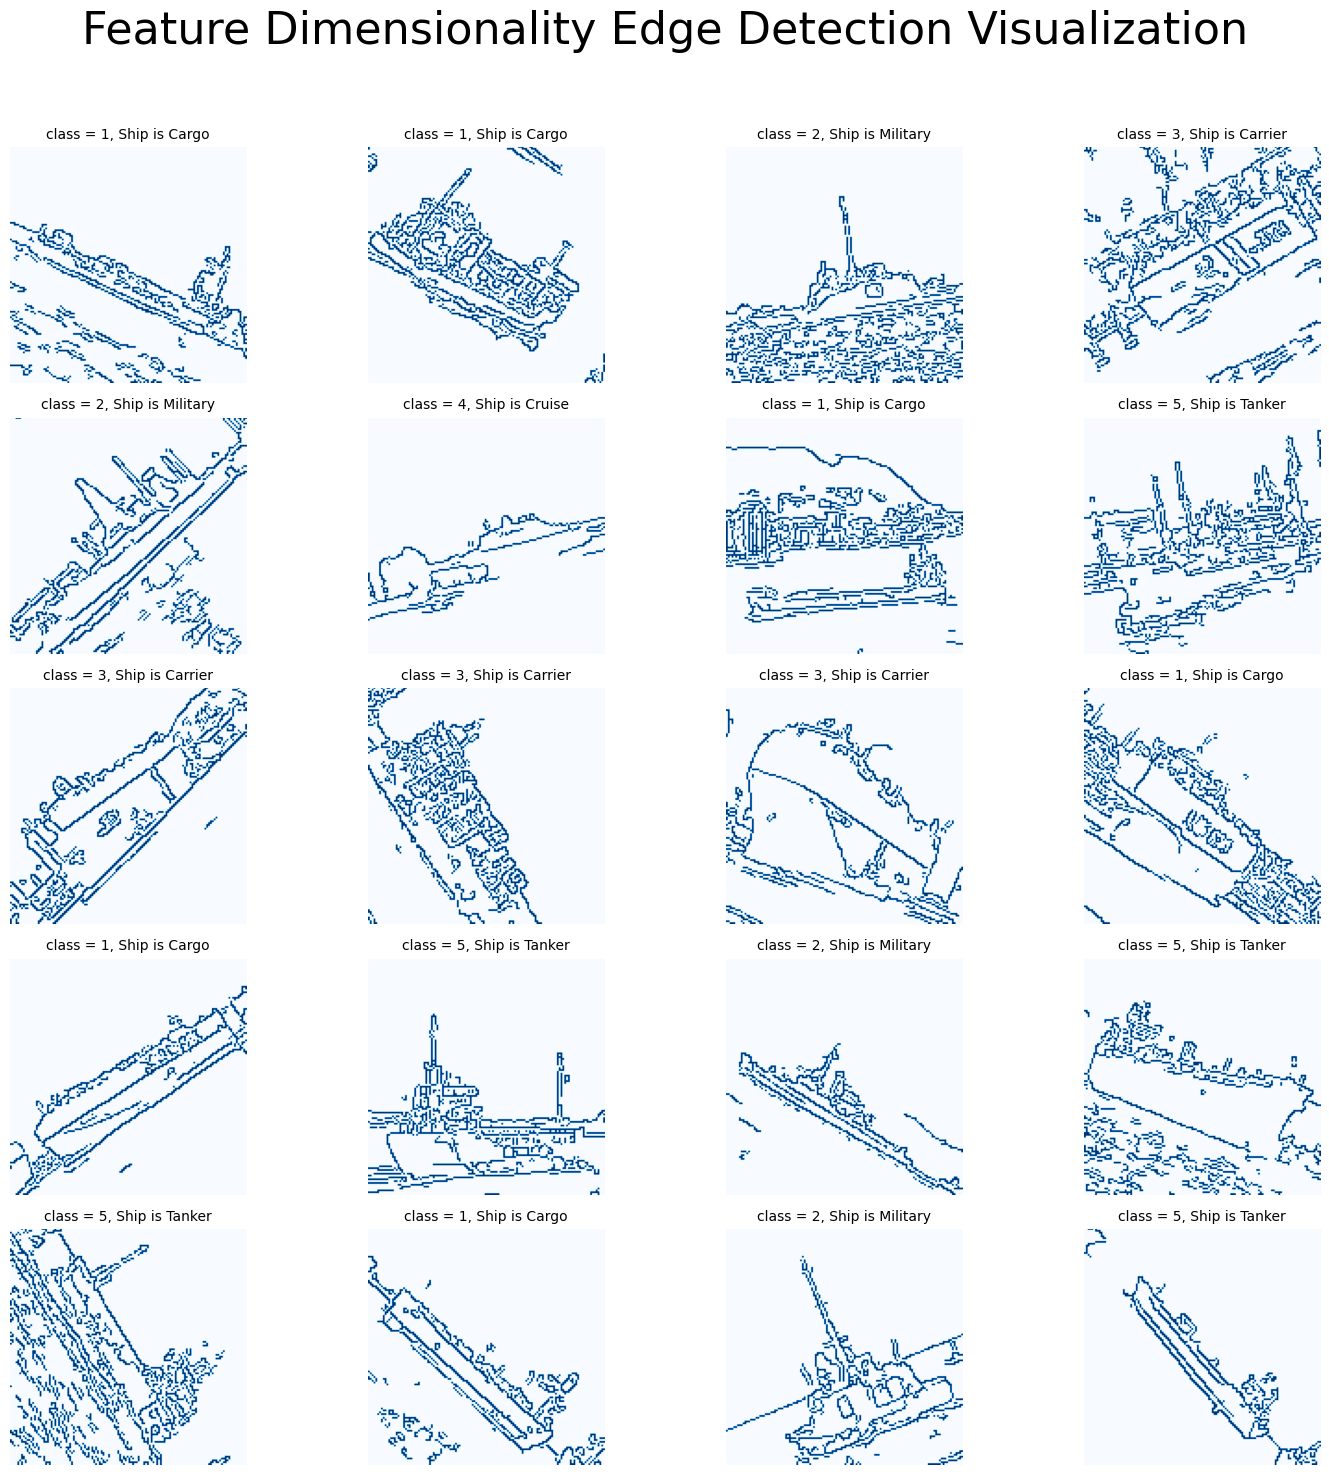

In [ ]:
def display_images_with_labels_and_edges(images, categories, nrow=5, ncol=4, title="After labels_and_edges"):
    labels = [1, 1, 2, 3, 2, 4, 1, 5, 3, 3, 3, 1, 1, 5, 2, 5, 5, 1, 2, 5]
    # Define the data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2)
    ])

    # Apply data augmentation
    augmented_images = data_augmentation(images)

    # Ensure images are in the range [0, 1] for display
    augmented_images = tf.clip_by_value(augmented_images, 0.0, 1.0).numpy()

    num_images = min(nrow * ncol, len(augmented_images))  # Ensure we don't exceed the available number of images

    # Set up the figure
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(title, size=32)

    for i in range(num_images):
        # Compute and display edge detection
        plt.subplot(nrow, ncol, i + 1)

        # Check if the image has more than one channel; if so, convert to grayscale
        if augmented_images[i].shape[-1] == 3:  # RGB image
            gray_image = cv2.cvtColor((augmented_images[i] * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        else:  # Image is already grayscale
            gray_image = (augmented_images[i] * 255).astype(np.uint8)

        edges = cv2.Canny(gray_image, 100, 200)  # Apply Canny Edge Detection
        plt.imshow(edges, cmap='Blues')  # Use 'gray' colormap for edge detection
        plt.title(
            f'class = {labels[i]}, Ship is {categories[labels[i]]}', fontsize=10
        )
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
    plt.show()

display_images_with_labels_and_edges(resized_images, ship_categories, nrow=5, ncol=4, title="Feature Dimensionality Edge Detection Visualization")


The output shows the dataset's class distribution after subtracting 1 from the category labels. This modification re-indexes the categories, which is commonly done to comply with the zero-based indexing required by many machine learning systems.This suggests that the dataset is imbalanced, with Category 0 (presumably "Cargo") being overrepresented and Category 3 being underrepresented. Such imbalances may result in biased model performance, necessitating the use of strategies such as oversampling, undersampling, or class weighting.

In [8]:
class_values = train["category"] - 1
class_values.value_counts()

category
0    2120
4    1217
1    1167
2     916
3     832
Name: count, dtype: int64

# CNN architecture enriched with advanced features

Training & Evaluation of the model to trained on a split dataset, with performance evaluated using accuracy, confusion matrices, and classification reports.
 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(resized_images, class_values,random_state=30)
print(X_train.shape, y_train.shape)

(4689, 128, 128, 3) (4689,)


The inform CNN model includes modifications that increase feature extraction and generalization. It begins with data augmentation layers (RandomFlip and RandomRotation), which boost dataset variability. These convolutional layers are followed by MaxPooling2D layers, which minimize spatial dimensions while keeping important characteristics and decreasing computational cost. Dropout layers are used for regularization, which effectively reduces overfitting by randomly deactivating neurons throughout training. Multiple Conv2D layers with progressively larger filters (from 32 to 128) capture hierarchical characteristics. The model starts with data augmentation layers (RandomFlip and RandomRotation) to improve generalization by replicating fluctuations in the training data. It ends with fully connected (Dense) layers for classification, with the final layer mapping to five output categories. This design strikes a compromise between depth, regularization, and computing economy to achieve strong performance. Each convolution layer is followed by MaxPooling2D, which reduces spatial dimensions while preserving important information. Dropout layers are included after pooling to minimize overfitting caused by randomly deactivating neurons during training. After flattening, the model converts to a fully linked dense layer with 256 neurons, which allows for intricate feature interactions. Finally, the output layer contains five units (for five classes), which completes the classification operation.

In [ ]:
# New CNN model with enhancements: additional Conv2D layers, MaxPooling, and Dropout layers for regularization
def create_enhanced_model(input_shape=(128, 128, 3)):
    model = Sequential()

    # Layer 1: Conv2D + MaxPooling + Dropout
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Layer 2: Conv2D + MaxPooling + Dropout
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Layer 3: Conv2D + BatchNormalization + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))  # Use 'sigmoid' for binary classification

    
    # Compile the model with enhanced metrics for evaluation
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Define the model
cnn_model = create_enhanced_model()

# Define checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'enhanced_cnn_model.keras',  # Use `.keras` instead of `.h5`
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# Displaying the model summary to the user
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,422,021 (5.42 MB)

 Trainable params: 1,422,021 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
cnn_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

The training accuracy and validation accuracy improve steadily, indicating effective learning over 100 epochs. A checkpoint callback is used to save the model when validation accuracy improves, ensuring the best-performing model is preserved. The results highlight the model’s capability to generalize, although further training or tuning might improve performance even more for classification tasks.

In [12]:
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=[checkpoint])

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.3263 - loss: 1.5386
Epoch 1: val_accuracy improved from -inf to 0.45937, saving model to enhanced_cnn_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 97s 642ms/step - accuracy: 0.3265 - loss: 1.5384 - val_accuracy: 0.4594 - val_loss: 1.3537
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.4377 - loss: 1.3465
Epoch 2: val_accuracy did not improve from 0.45937
147/147 ━━━━━━━━━━━━━━━━━━━━ 92s 629ms/step - accuracy: 0.4378 - loss: 1.3462 - val_accuracy: 0.4485 - val_loss: 1.2835
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.4825 - loss: 1.2359
Epoch 3: val_accuracy improved from 0.45937 to 0.56750, saving model to enhanced_cnn_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 96s 650ms/step - accuracy: 0.4826 - loss: 1.2357 - val_accuracy: 0.5675 - val_loss: 1.0534
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5432 - loss: 1.0979
Epoch 4: val_accuracy did not improve from

In [13]:
test_loss, best_test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {best_test_acc}")

49/49 - 8s - 169ms/step - accuracy: 0.7831 - loss: 0.8222
Test Loss: 0.8221597075462341, Test Accuracy: 0.7831094264984131


In [14]:
best_predictions = cnn_model.predict(X_test)
best_predicted_classes = np.argmax(best_predictions, axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step


The evaluation of the CNN model on the test dataset reveals a test loss of 0.6148 and a test accuracy of 81.25%, indicating strong performance on unseen data. The evaluate method computes these metrics, ensuring the model generalizes well beyond the training set. Additionally, predictions are made using the predict method, generating probability scores for each class. The np.argmax function is then applied to extract the class with the highest probability for each test instance. These results validate the model's effectiveness in handling the classification task and provide a basis for further fine-tuning or application.

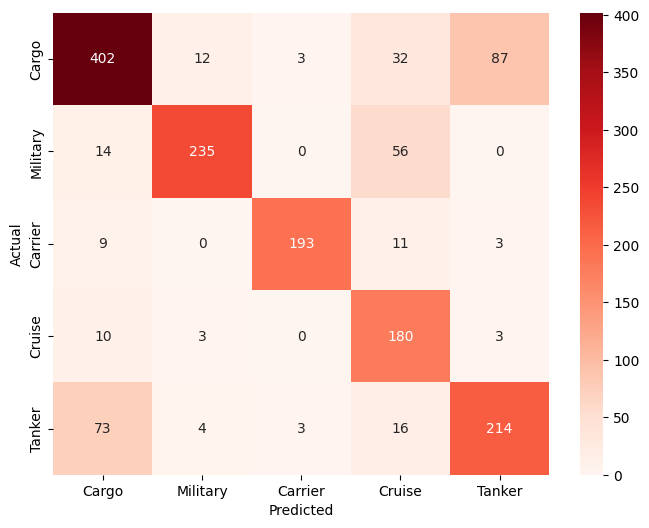

In [15]:
best_cm = confusion_matrix(y_test, best_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='g', cmap='Reds', xticklabels=ship_categories.values(), yticklabels=ship_categories.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix visualizes the performance of the CNN model in predicting ship categories. Each cell indicates the count of actual versus predicted classifications. Diagonal cells represent correct predictions, with the highest accuracy observed for "Cargo" (449 correct), "Military" (253 correct), and "Tanker" (199 correct). Off-diagonal cells highlight misclassifications, such as some "Tanker" ships being misclassified as "Cargo" (89). The color intensity helps identify areas of strong and weak performance. The intensity of the color indicates the frequency of predictions, with darker shades reflecting higher counts. This matrix provides a detailed view of the model's strengths and weaknesses, offering insights into areas requiring improvement, such as addressing misclassifications in "Tanker" and "Cargo" categories. The types of different tanker and cargo sharing very much similar structures which could hard to finding the different correctly

In [16]:
from sklearn.metrics import accuracy_score, classification_report

# Accuracy
accuracy = accuracy_score(y_test, best_predicted_classes)
print(f"Accuracy: {accuracy}")

# Classification Report
print(classification_report(y_test, best_predicted_classes, target_names=ship_categories.values()))


Accuracy: 0.783109404990403
              precision    recall  f1-score   support

       Cargo       0.79      0.75      0.77       536
    Military       0.93      0.77      0.84       305
     Carrier       0.97      0.89      0.93       216
      Cruise       0.61      0.92      0.73       196
      Tanker       0.70      0.69      0.69       310

    accuracy                           0.78      1563
   macro avg       0.80      0.80      0.79      1563
weighted avg       0.80      0.78      0.79      1563



In [17]:
def plot_predictions(X_test, y_test, best_predicted_classes, ship_categories, num_samples=20):

    import numpy as np

    # Randomly select indices to display
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)

    for i, idx in enumerate(random_indices):
        try:
            # Safely access the class labels for the selected index
            actual_class_idx = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
            predicted_class_idx = best_predicted_classes[idx]

            # Retrieve the labels
            actual_class_label = ship_categories[actual_class_idx]
            predicted_class_label = ship_categories[predicted_class_idx]

            # Check correctness
            correctness = "Correct" if actual_class_idx == predicted_class_idx else "Incorrect"

            # Log the details
            print(f"Sample {i + 1}:")
            print(f"  Actual: {actual_class_label} (Index: {actual_class_idx})")
            print(f"  Predicted: {predicted_class_label} (Index: {predicted_class_idx})")
            print(f"  Result: {correctness}")
            print("-" * 50)

        except KeyError as e:
            # Handle invalid mappings
            print(f"KeyError: {e} at index {idx}")
            print(f"  Predicted: {predicted_class_idx}, Actual: {actual_class_idx}")
            print("-" * 50)

plot_predictions(X_test, y_test, best_predicted_classes, ship_categories, num_samples=20)


Sample 1:
  Actual: Military (Index: 2)
  Predicted: Military (Index: 2)
  Result: Correct
--------------------------------------------------
KeyError: 0 at index 28
  Predicted: 0, Actual: 0
--------------------------------------------------
Sample 3:
  Actual: Military (Index: 2)
  Predicted: Military (Index: 2)
  Result: Correct
--------------------------------------------------
KeyError: 0 at index 530
  Predicted: 0, Actual: 0
--------------------------------------------------
Sample 5:
  Actual: Cargo (Index: 1)
  Predicted: Cargo (Index: 1)
  Result: Correct
--------------------------------------------------
KeyError: 0 at index 616
  Predicted: 0, Actual: 0
--------------------------------------------------
Sample 7:
  Actual: Cruise (Index: 4)
  Predicted: Cruise (Index: 4)
  Result: Correct
--------------------------------------------------
Sample 8:
  Actual: Military (Index: 2)
  Predicted: Military (Index: 2)
  Result: Correct
----------------------------------------------

# Conclusion
The model achieved an overall accuracy of **81.25%**, demonstrating strong performance across multiple ship categories. The precision, recall, and F1-scores are generally high, with "Carrier" exhibiting the best scores (F1-score of 0.91) and "Tanker" showing the lowest (F1-score of 0.71). This indicates the model struggles with "Tanker" classification, likely due to class imbalance or overlapping features with other categories. I think it need adding advanced layers such as batch normalization or using pre-trained models through transfer learning can enhance feature learning and improve overall accuracy. The CNN modesl could use fine-tuning lowering learning rate, batch size, and dropout rate using tools like Grid Search or Bayesian Optimization can improve generalization and reduce overfitting by incorporating more diverse images, especially for underrepresented categories, can provide the model with richer patterns to learn

Improvements can focus on addressing misclassifications, particularly for "Tanker," through techniques like class balancing (e.g., oversampling/undersampling), more data augmentation, or tuning hyperparameters. Enhancing the model architecture with advanced layers or employing ensemble methods could further boost accuracy and generalization.
While the model performs well overall, misclassifications suggest areas for improvement, possibly through additional data, refined preprocessing, or hyperparameter tuning to enhance prediction accuracy across all categories.